In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor


from torch.utils.data import TensorDataset, DataLoader, Dataset

import torch.nn.functional as F

import numpy as np


import matplotlib.pyplot as plt

from PIL import Image

import os
import glob


from MyDataLoader import ShuffleDataLoader
from FileReader import get_picture_tensors
from MyModels import CatNet
from ModelEvaluation import eval_model

from ImageProcessing import display_train_and_test_images


In [16]:
# data params
#root_directory = "selected_datasets/prep_no_back/"
root_directory = "dataset/normal_prep_datasets/dataset_chat_downscale_no_background/"
n_classes = 100
required_train_imgs = 8
required_test_imgs = 1

In [17]:
(train_images, val_images, test_images, 
 train_labels, val_labels, test_labels, n_classes) = get_picture_tensors(root_directory=root_directory,
                                                              n_classes=n_classes, 
                                                              required_train_imgs=required_train_imgs, 
                                                              required_test_imgs=required_test_imgs,
                                                              use_selected_eval_datasets = False)

Chargement de dataset/normal_prep_datasets/dataset_chat_downscale_no_background/0001  ->  10/17 images
Chargement de dataset/normal_prep_datasets/dataset_chat_downscale_no_background/0002  ->  10/20 images
Chargement de dataset/normal_prep_datasets/dataset_chat_downscale_no_background/0003  ->  10/15 images
Chargement de dataset/normal_prep_datasets/dataset_chat_downscale_no_background/0004  ->  10/56 images
Chargement de dataset/normal_prep_datasets/dataset_chat_downscale_no_background/0005  ->  10/41 images
Chargement de dataset/normal_prep_datasets/dataset_chat_downscale_no_background/0006  ->  10/40 images
Chargement de dataset/normal_prep_datasets/dataset_chat_downscale_no_background/0007  ->  10/41 images
Chargement de dataset/normal_prep_datasets/dataset_chat_downscale_no_background/0008  ->  10/18 images
Chargement de dataset/normal_prep_datasets/dataset_chat_downscale_no_background/0009  ->  10/13 images
Chargement de dataset/normal_prep_datasets/dataset_chat_downscale_no_back

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

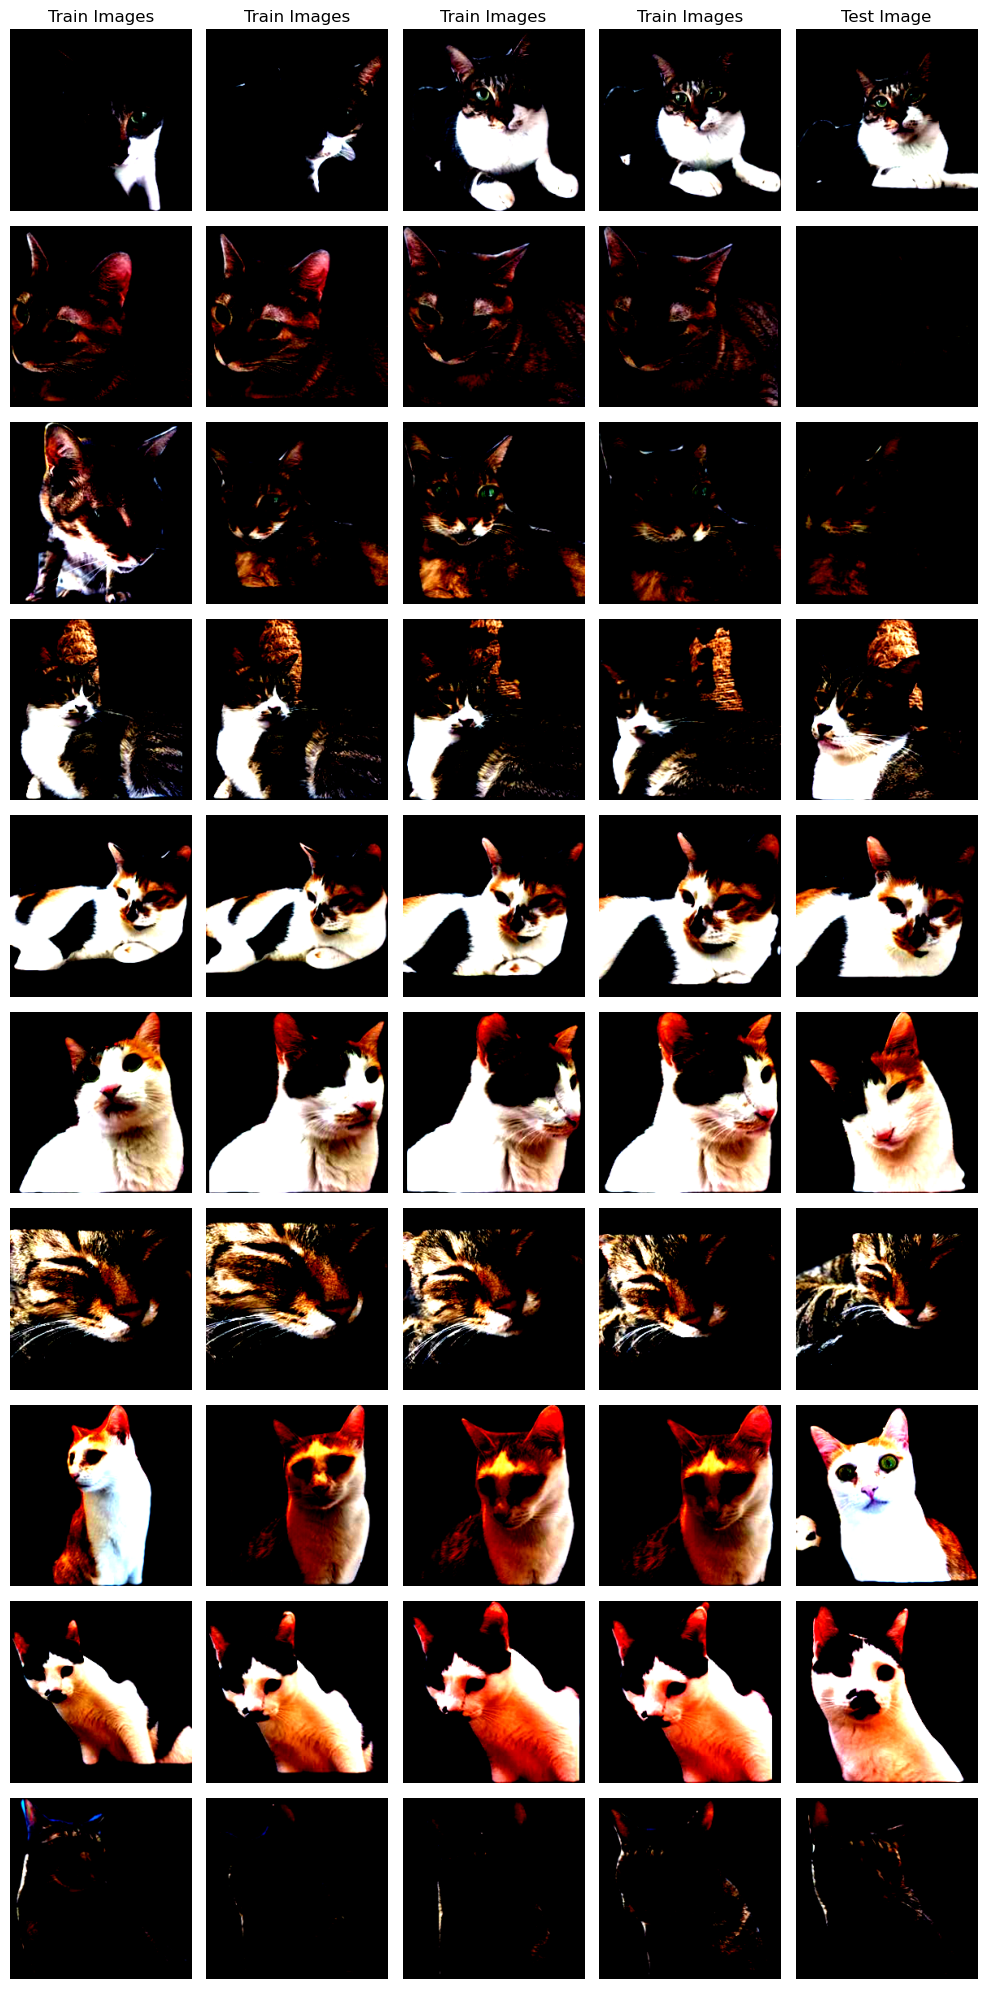

In [18]:
#  (1,2,0) avec du preprocessing, (0,1,2) sans, jsp pourquoi
# il y aura du spam de warning, ignore ça
display_train_and_test_images(train_images, test_images, required_train_imgs, (1,2,0))

End of epoch 0
Likelyhood of finding correct cat in the most likely 5 cats predicted by the model, on validation dataset: 95.00%


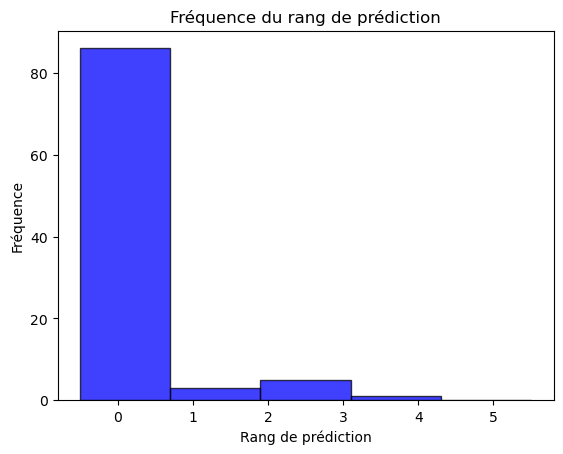

End of epoch 1
Likelyhood of finding correct cat in the most likely 5 cats predicted by the model, on validation dataset: 97.00%


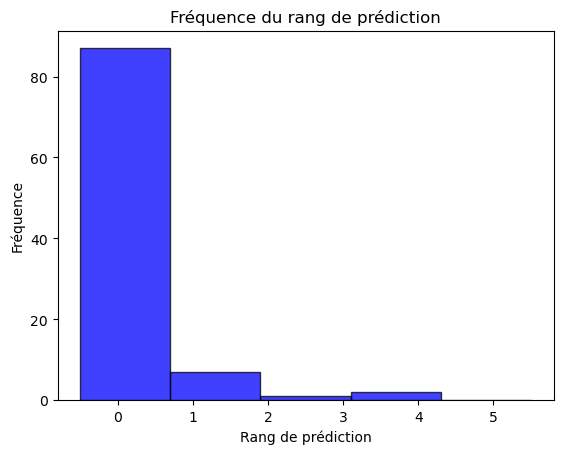

End of epoch 2
Likelyhood of finding correct cat in the most likely 5 cats predicted by the model, on validation dataset: 94.00%


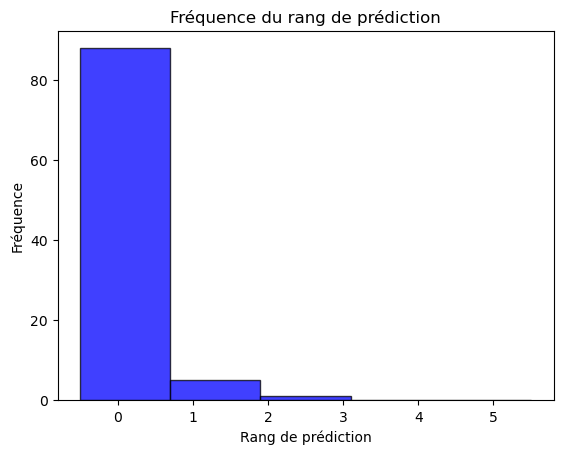

End of epoch 3
Likelyhood of finding correct cat in the most likely 5 cats predicted by the model, on validation dataset: 97.00%


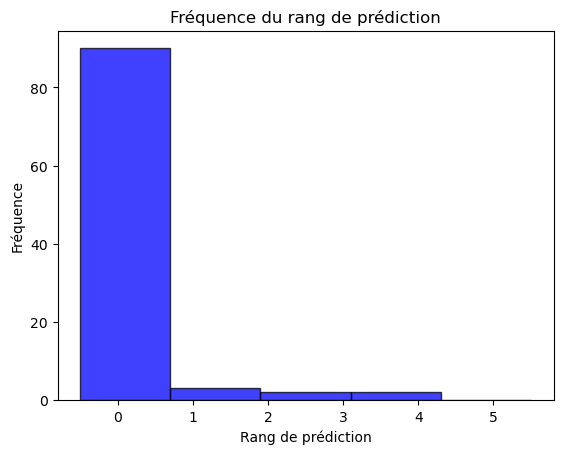

Training and evaluation finished.


In [19]:
# params du modèle, essayer avec gridsearch (idéalement Randomized pour ne pas prendre énormément de temps), avec une bonne machine durant la nuit ou qqch
# faudrait idéalement logger les performances selon chaque combination de params pour s'amuser
# num_epochs = 6
num_epochs = 4
batch_size = 8
learning_rate = 1e-3


train_dataset = ShuffleDataLoader(train_images, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_dataset = ShuffleDataLoader(val_images, val_labels)

model = CatNet(n_classes)

model.train()

criterion = nn.CrossEntropyLoss()
params = filter(lambda x: x.requires_grad, model.parameters())
optimizer = optim.Adam(params, lr = learning_rate)



accuracy_at_each_epoch = []
for epoch in range(num_epochs):
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"End of epoch {epoch}")
    accuracy_at_each_epoch.append(eval_model(model, val_dataset, 5  ))
    
    
print('Training and evaluation finished.')

In [20]:
# # Décommenter pour rouler d'autre épochs supplémentaires sans repartir de 0
# for epoch in range(num_epochs):
#     for images, labels in train_dataloader:
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#     accuracy_at_each_epoch.append(eval_model(model, val_dataset))
    
# print('Training and evaluation finished.')

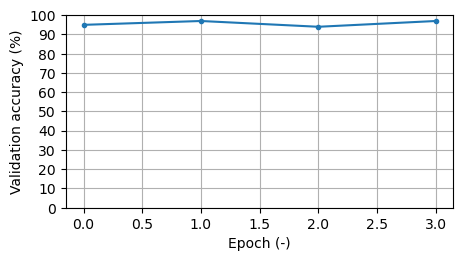

In [21]:
from matplotlib.ticker import MultipleLocator


fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))

ax.set_xlabel('Epoch (-)')
ax.set_ylabel('Validation accuracy (%)')
ax.set_ylim(0, 100)
ax.set_yticks(np.arange(0, 110, 10))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.plot(accuracy_at_each_epoch, '.-')

plt.grid(True)


In [22]:
# # Pour loader des nouvelles données à tester
# # Problème avec les labels!

# # root_dir = "dataset_chat_downscale"
# root_dir = "dataset_chat_downscale_no_background"
# (train_images, val_images, test_images, 
#  train_labels, val_labels, test_labels) = get_picture_tensors(root_dir, n_classes=n_classes,
#                                                required_train_imgs=required_test_imgs,
#                                                required_test_imgs=required_test_imgs)

# # array of 10 zeros
# index = np.zeros(len(test_images))
# score = np.zeros(len(test_images))
# for i in range(len(test_images)-1, 0, -1):
#     test_images = test_images[:i]  # sa réduit la taille jusqu'à 0.. 
#     test_labels = test_labels[:i]
#     test_dataset = ShuffleDataLoader(test_images, test_labels)
#     # print(test_labels_i)
#     index[i] = i
#     score[i] = eval_model(model, test_dataset)

In [23]:
# plt.plot(index, score)
# plt.xlabel('Number of test images')
# plt.ylabel('Accuracy (%)')

Likelyhood of finding correct cat in the most likely 3 cats predicted by the model, on test dataset: 98.00%


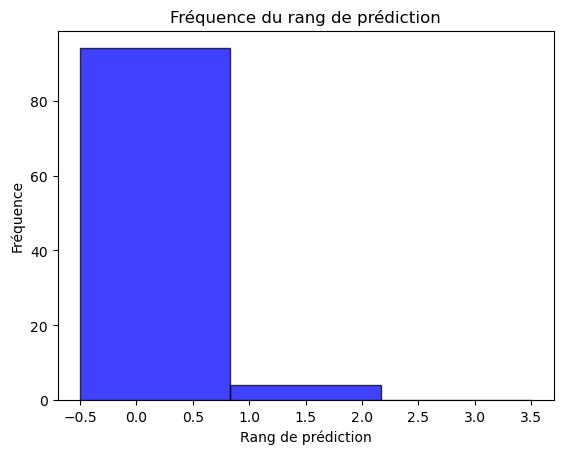

98.0

In [24]:
test_dataset = ShuffleDataLoader(test_images, test_labels)
eval_model(model, test_dataset, 3, type_of_dataset="test")